<a href="https://colab.research.google.com/github/OsaVS/cnn-realwaste/blob/main/custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Material Classification using CNN

This notebook implements a Convolutional Neural Network to classify waste materials into 9 categories: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, and Vegetation.


### Import Libraries

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Install kaggle

### Subtask:
Install the Kaggle library in the notebook environment.


**Reasoning**:
The subtask is to install the Kaggle library. The instruction specifies using `pip install kaggle` in a code cell.



In [85]:
%pip install kaggle

## Set up kaggle credentials

### Subtask:
Guide the user on how to obtain their Kaggle API key and store it securely in the notebook environment.


**Reasoning**:
Provide instructions to the user on how to obtain their Kaggle API key and securely store it in the notebook environment.



In [86]:
print("Please follow these steps to obtain and store your Kaggle API key:")
print("1. Go to your Kaggle account settings.")
print("2. Under the 'API' section, click 'Create New API Token'. This will download a 'kaggle.json' file.")
print("3. In the notebook environment, navigate to the file explorer (usually a folder icon on the left sidebar).")
print("4. Click the upload button (usually an upward arrow icon) and upload the 'kaggle.json' file you just downloaded.")
print("5. Run the following code in a code cell to create the necessary directory and move the uploaded 'kaggle.json' file to that directory:")
print("\n!mkdir -p ~/.kaggle")
print("!mv kaggle.json ~/.kaggle/")
print("!chmod 600 ~/.kaggle/kaggle.json")

Please follow these steps to obtain and store your Kaggle API key:
1. Go to your Kaggle account settings.
2. Under the 'API' section, click 'Create New API Token'. This will download a 'kaggle.json' file.
3. In the notebook environment, navigate to the file explorer (usually a folder icon on the left sidebar).
4. Click the upload button (usually an upward arrow icon) and upload the 'kaggle.json' file you just downloaded.
5. Run the following code in a code cell to create the necessary directory and move the uploaded 'kaggle.json' file to that directory:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [87]:
!mkdir -p ~/.kaggle

In [88]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [89]:
!chmod 600 ~/.kaggle/kaggle.json

## Download dataset

### Subtask:
Write the code to download the specified dataset from Kaggle using the installed library and credentials.


**Reasoning**:
Download the specified dataset from Kaggle and unzip it.



In [90]:
import kaggle
kaggle.api.dataset_download_files('rtti237/realwaste-dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rtti237/realwaste-dataset


## Verify dataset location

### Subtask:
Show the user where the downloaded dataset is located in the notebook's file system.


**Reasoning**:
List the contents of the current directory to show the downloaded dataset files and folders.



In [91]:
%ls

best_waste_model.pth  RealWaste/  sample_data/


## Update data dir

### Subtask:
Modify the `DATA_DIR` variable to point to the location of the downloaded dataset.


**Reasoning**:
Update the DATA_DIR variable to the correct path of the downloaded dataset directory, which is 'RealWaste' in the current directory.



In [92]:
DATA_DIR = './RealWaste'
print(f"Updated DATA_DIR: {DATA_DIR}")

Updated DATA_DIR: ./RealWaste


## Dataset Configuration
- Resize the 524x524 to 224x224
- Set the batch size to 32. The number of data samples (images) that will be processed simultaneously during one forward/backward pass of the model
- Number of distinct classes for which the classification should be done is set to 9.
- Total number of epoch count is set to 20.

In [93]:
# Dataset parameters
IMAGE_SIZE = 224 # Updated image size
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 50

# Class names and their counts
CLASS_NAMES = [
    'Cardboard',         # 461
    'Food Organics',     # 411
    'Glass',             # 420
    'Metal',             # 790
    'Miscellaneous Trash',     # 495
    'Paper',             # 500
    'Plastic',           # 921
    'Textile Trash',           # 318
    'Vegetation'         # 436
]

# DATA_DIR = '/home/ravindu/Documents/Projects/cnn-realwaste/realwaste/realwaste-main/RealWaste'

## Dataset class

In [94]:
class WasteDataset(Dataset):
    """Fixed Custom Dataset for loading waste material images"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        # Load all images and labels with SORTING
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                # ✅ SORT FILES to ensure consistent ordering
                image_files = sorted(class_dir.glob('*.*'))

                for img_path in image_files:
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)
            else:
                print(f"⚠️ Warning: Directory not found: {class_dir}")

        print(f"Loaded {len(self.images)} images from {len(CLASS_NAMES)} classes")

        # ✅ ADD: Verify we have images
        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return black image if error
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

## Calculating normalization values
- Calculate μ and σ for each channel (R, G, B) of the specific training set using 1000 images from that dataset.

In [95]:
def calculate_mean_std(dataset_path, image_size=224, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = torch.utils.data.Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=4)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    print(f"Dataset Mean (R, G, B): [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
    print(f"Dataset Std (R, G, B): [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

    return mean.tolist(), std.tolist()

dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)

Loaded 4752 images from 9 classes


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Dataset Mean (R, G, B): [0.5959, 0.6181, 0.6327]
Dataset Std (R, G, B): [0.1614, 0.1624, 0.1879]


## Data augmentation and pre-processing
### Training dataset
- Resizing
- Random horizontal flip
- Random rotation
- Color jitter (Randomly alter the brightness, contrast, and saturation)
- Convert the image from a PIL Image to a PyTorch Tensor and automatically scale pixel values from [0,255] to the floating-point range of [0.0,1.0]
- Standardize the Tensor data

### Validation data set
- Resizing
- Tensor conversion
- Normalization


In [96]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0), ratio=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.15),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.2), ratio=(0.3,3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.15)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])


## Load and split data set
- Load the full data set and split it into 70% training, 15% validation and 15% testing.
- Create the necessary data loaders

In [97]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset

print("="*70)
print("LOADING AND SPLITTING DATASET")
print("="*70)

# ✅ STEP 1: Define split ratios FIRST
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

print(f"\nSplit ratios:")
print(f"  Training:   {train_ratio*100:.0f}%")
print(f"  Validation: {val_ratio*100:.0f}%")
print(f"  Testing:    {test_ratio*100:.0f}%")

# ✅ STEP 2: Create full dataset (without transforms for now)
print(f"\nLoading dataset from: {DATA_DIR}")
full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)

# ✅ STEP 3: Extract all labels
print("\nExtracting labels...")
labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])

print(f"\nLabel distribution in full dataset:")
unique, counts = np.unique(labels, return_counts=True)
for label_idx, count in zip(unique, counts):
    print(f"  {CLASS_NAMES[label_idx]:20s}: {count:4d} images ({count/len(labels)*100:.1f}%)")

# ✅ STEP 4: First split - separate training from (validation + test)
print(f"\n1️⃣ Splitting: Train vs (Val + Test)...")
sss1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=(val_ratio + test_ratio),
    random_state=42
)
train_idx, temp_idx = next(sss1.split(np.arange(len(labels)), labels))

print(f"  Train: {len(train_idx)} images")
print(f"  Temp:  {len(temp_idx)} images")

# ✅ STEP 5: Second split - separate validation from test
print(f"\n2️⃣ Splitting: Val vs Test...")
temp_labels = labels[temp_idx]
relative_test_size = test_ratio / (val_ratio + test_ratio)

sss2 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=relative_test_size,
    random_state=42
)
val_idx_rel, test_idx_rel = next(sss2.split(np.arange(len(temp_idx)), temp_labels))

# Convert relative indices to absolute indices
val_idx = temp_idx[val_idx_rel]
test_idx = temp_idx[test_idx_rel]

print(f"  Val:  {len(val_idx)} images")
print(f"  Test: {len(test_idx)} images")

# ✅ STEP 6: Verify split is stratified
print("\n" + "="*70)
print("VERIFYING STRATIFIED SPLIT")
print("="*70)

def print_split_distribution(indices, split_name):
    split_labels = labels[indices]
    print(f"\n{split_name} distribution:")
    unique, counts = np.unique(split_labels, return_counts=True)
    for label_idx, count in zip(unique, counts):
        percentage = count / len(split_labels) * 100
        print(f"  {CLASS_NAMES[label_idx]:20s}: {count:4d} ({percentage:5.1f}%)")

print_split_distribution(train_idx, "TRAINING")
print_split_distribution(val_idx, "VALIDATION")
print_split_distribution(test_idx, "TESTING")

# ✅ STEP 7: Create separate dataset objects WITH transforms
print("\n" + "="*70)
print("CREATING DATASETS WITH TRANSFORMS")
print("="*70)

# Create three separate dataset instances
train_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=train_transform)
val_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)
test_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)

# Create subsets
train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)
test_dataset = Subset(test_dataset_full, test_idx)

print(f"\n✅ Datasets created:")
print(f"  Training:   {len(train_dataset):4d} images with augmentation")
print(f"  Validation: {len(val_dataset):4d} images (no augmentation)")
print(f"  Testing:    {len(test_dataset):4d} images (no augmentation)")

# ✅ STEP 8: Create DataLoaders
print("\n" + "="*70)
print("CREATING DATA LOADERS")
print("="*70)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    drop_last=False
)

print(f"\n✅ Data loaders created:")
print(f"  Training:   {len(train_loader):4d} batches (batch_size={BATCH_SIZE})")
print(f"  Validation: {len(val_loader):4d} batches (batch_size={BATCH_SIZE})")
print(f"  Testing:    {len(test_loader):4d} batches (batch_size={BATCH_SIZE})")

# ✅ STEP 9: Quick sanity check
print("\n" + "="*70)
print("SANITY CHECK")
print("="*70)

# Test one batch
images, batch_labels = next(iter(train_loader))
print(f"\n✅ Successfully loaded a batch:")
print(f"  Image shape: {images.shape}")
print(f"  Label shape: {batch_labels.shape}")
print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")
print(f"  Labels in batch: {batch_labels.tolist()[:10]}...")

print("\n" + "="*70)
print("✅ DATASET LOADING COMPLETE!")
print("="*70)

LOADING AND SPLITTING DATASET

Split ratios:
  Training:   70%
  Validation: 15%
  Testing:    15%

Loading dataset from: ./RealWaste
Loaded 4752 images from 9 classes

Extracting labels...

Label distribution in full dataset:
  Cardboard           :  461 images (9.7%)
  Food Organics       :  411 images (8.6%)
  Glass               :  420 images (8.8%)
  Metal               :  790 images (16.6%)
  Miscellaneous Trash :  495 images (10.4%)
  Paper               :  500 images (10.5%)
  Plastic             :  921 images (19.4%)
  Textile Trash       :  318 images (6.7%)
  Vegetation          :  436 images (9.2%)

1️⃣ Splitting: Train vs (Val + Test)...
  Train: 3326 images
  Temp:  1426 images

2️⃣ Splitting: Val vs Test...
  Val:  713 images
  Test: 713 images

VERIFYING STRATIFIED SPLIT

TRAINING distribution:
  Cardboard           :  323 (  9.7%)
  Food Organics       :  288 (  8.7%)
  Glass               :  294 (  8.8%)
  Metal               :  553 ( 16.6%)
  Miscellaneous Trash :  3

In [98]:
from collections import Counter

print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS FOR IMBALANCED DATASET")
print("="*70)

# Get training labels
train_labels = labels[train_idx].tolist()
class_counts = Counter(train_labels)

# Compute inverse frequency weights
total_train = len(train_labels)
class_weights = torch.tensor(
    [total_train / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)],
    dtype=torch.float32
).to(device)

print("\n📊 Class weights (higher = minority class):")
for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"  {name:20s}: {weight:.3f} (count: {class_counts[i]:3d})")

# Use weighted loss
criterion = nn.CrossEntropyLoss(weight=class_weights)
print("\n✅ Weighted CrossEntropyLoss created")


COMPUTING CLASS WEIGHTS FOR IMBALANCED DATASET

📊 Class weights (higher = minority class):
  Cardboard           : 1.144 (count: 323)
  Food Organics       : 1.283 (count: 288)
  Glass               : 1.257 (count: 294)
  Metal               : 0.668 (count: 553)
  Miscellaneous Trash : 1.068 (count: 346)
  Paper               : 1.056 (count: 350)
  Plastic             : 0.573 (count: 645)
  Textile Trash       : 1.665 (count: 222)
  Vegetation          : 1.212 (count: 305)

✅ Weighted CrossEntropyLoss created


## CNN model architecture
### Feature Extraction

- Convo1ution layer 1: 32 filters, 5x5 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 2: 64 filters, 3x3 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 3: 128 filters, 3x3 kernel, ReLU activation (added for better feature extraction)
- MaxPool: 2x2

### Classification
- Flatten
- Fully Connected layer 1: 512 units, ReLU activation
    - with Dropout: 0.5
- Fully Connected layer 2: 256 units, ReLU activation
    - With Dropout: 0.3
- Output: 9 units, Softmax

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

print("="*70)
print("BUILDING CUSTOM WASTENET-DEEP ARCHITECTURE")
print("="*70)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block for channel attention"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ResidualBlock(nn.Module):
    """Residual Block with Batch Normalization"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class PyramidPooling(nn.Module):
    """Pyramid Pooling Module for multi-scale feature aggregation"""
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()

        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool3 = nn.AdaptiveAvgPool2d(4)

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)
        self.conv3 = nn.Conv2d(in_channels, in_channels // 4, 1, bias=False)

    def forward(self, x):
        size = x.size()[2:]

        feat1 = F.interpolate(self.conv1(self.pool1(x)), size=size, mode='bilinear', align_corners=True)
        feat2 = F.interpolate(self.conv2(self.pool2(x)), size=size, mode='bilinear', align_corners=True)
        feat3 = F.interpolate(self.conv3(self.pool3(x)), size=size, mode='bilinear', align_corners=True)

        return torch.cat([x, feat1, feat2, feat3], dim=1)


class WasteNetDeep(nn.Module):
    """Custom Deep CNN for Waste Classification"""

    def __init__(self, num_classes=9):
        super(WasteNetDeep, self).__init__()

        print("\n🏗️  Building WasteNet-Deep Architecture...")

        # Initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # Output: 64 × 56 × 56

        # Block 1: 56×56
        self.block1 = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            SEBlock(64)
        )

        # Block 2: 28×28
        self.block2 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            SEBlock(128)
        )

        # Block 3: 14×14
        self.block3 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            SEBlock(256)
        )

        # Block 4: 7×7
        self.block4 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512),
            ResidualBlock(512, 512),
            SEBlock(512)
        )

        # Pyramid pooling
        self.pyramid = PyramidPooling(512)
        # Output: 896 channels (512 + 128 + 128 + 128)

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(896, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        # Initialize weights - FIXED VERSION
        self._initialize_weights()

        print("✅ Architecture built successfully!")

    def _initialize_weights(self):
        """Fixed weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ✅ Check if bias exists
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                if m.weight is not None:  # ✅ Check if weight exists
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:  # ✅ Check if bias exists
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:  # ✅ Check if bias exists
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv
        x = self.conv1(x)

        # Feature extraction blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Multi-scale features
        x = self.pyramid(x)

        # Global pooling
        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        # Classification
        x = self.classifier(x)

        return x


# Clear previous model
if 'model' in globals():
    del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Create model
model = WasteNetDeep(num_classes=NUM_CLASSES).to(device)

# Model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*70)
print("MODEL STATISTICS")
print("="*70)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

# Architecture summary
print("\n📐 Architecture Summary:")
print("  Input: 3 × 224 × 224")
print("  ├─ Conv1 (7×7, stride 2) → 64 × 112 × 112")
print("  ├─ MaxPool → 64 × 56 × 56")
print("  ├─ Block1 (2 ResBlocks + SE) → 64 × 56 × 56")
print("  ├─ Block2 (3 ResBlocks + SE) → 128 × 28 × 28")
print("  ├─ Block3 (4 ResBlocks + SE) → 256 × 14 × 14")
print("  ├─ Block4 (3 ResBlocks + SE) → 512 × 7 × 7")
print("  ├─ Pyramid Pooling → 896 × 7 × 7")
print("  ├─ Global Avg Pool → 896")
print("  └─ Classifier (FC layers) → 9")
print("\n✅ Model ready for training!")

BUILDING CUSTOM WASTENET-DEEP ARCHITECTURE

🏗️  Building WasteNet-Deep Architecture...
✅ Architecture built successfully!

MODEL STATISTICS
Total parameters: 19,388,489
Trainable parameters: 19,388,489
Model size: ~74.0 MB

📐 Architecture Summary:
  Input: 3 × 224 × 224
  ├─ Conv1 (7×7, stride 2) → 64 × 112 × 112
  ├─ MaxPool → 64 × 56 × 56
  ├─ Block1 (2 ResBlocks + SE) → 64 × 56 × 56
  ├─ Block2 (3 ResBlocks + SE) → 128 × 28 × 28
  ├─ Block3 (4 ResBlocks + SE) → 256 × 14 × 14
  ├─ Block4 (3 ResBlocks + SE) → 512 × 7 × 7
  ├─ Pyramid Pooling → 896 × 7 × 7
  ├─ Global Avg Pool → 896
  └─ Classifier (FC layers) → 9

✅ Model ready for training!


## Loss function and Optimizer
- Loss function -> Cross entropy loss
- Optimizer -> Adaptive Moment Estimation (ADAM)
- Learning rate scheduler -> Reduce LR On Plateau

In [100]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        self.best_model = {k: v.cpu().clone() for k, v in model.state_dict().items()}

early_stopping = EarlyStopping(patience=10)
best_val_acc = 0.0

print("✅ Early stopping enabled (patience=10)")

✅ Early stopping enabled (patience=10)


## Training CONFIGURATION

In [101]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION FOR WASTENET-DEEP")
print("="*70)

# Training settings
NUM_EPOCHS = 60
LEARNING_RATE = 0.001

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
print(f"✅ Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")

# Learning rate scheduler - Cosine with warm restart
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=15,      # First cycle: 15 epochs
    T_mult=1,    # Each cycle same length
    eta_min=1e-6
)
print(f"✅ Scheduler: CosineAnnealingWarmRestarts (T_0=15)")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
print(f"✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights")

# Early stopping
early_stopping = EarlyStopping(patience=15, min_delta=0.001)
print(f"✅ Early Stopping: patience=15")

print(f"\n🎯 Expected accuracy with custom architecture: 82-90%")


TRAINING CONFIGURATION FOR WASTENET-DEEP
✅ Optimizer: AdamW (lr=0.001, weight_decay=1e-4)
✅ Scheduler: CosineAnnealingWarmRestarts (T_0=15)
✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights
✅ Early Stopping: patience=15

🎯 Expected accuracy with custom architecture: 82-90%


## Training Loop

In [102]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Training for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


print("\n" + "="*70)
print("STARTING TRAINING - CUSTOM WASTENET-DEEP")
print("="*70)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

best_val_acc = 0.0
best_epoch = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print progress
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] ({epoch_time:4.1f}s) | "
          f"LR: {current_lr:.6f} | "
          f"Train: {train_acc:5.2f}% | "
          f"Val: {val_acc:5.2f}%", end='')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'history': history
        }, 'best_wastenet_deep.pth')
        print(" ✨ BEST!", end='')

    print()

    # Milestone messages
    if epoch > 0:
        if val_acc >= 80 and history['val_acc'][-2] < 80:
            print("   🎯 Milestone: 80% accuracy reached!")
        elif val_acc >= 85 and history['val_acc'][-2] < 85:
            print("   🎉 Milestone: 85% accuracy reached!")
        elif val_acc >= 90 and history['val_acc'][-2] < 90:
            print("   🏆 EXCELLENT: 90% TARGET ACHIEVED!")

    # Early stopping check
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"\n⏹️  Early stopping triggered at epoch {epoch+1}")
        break

total_time = time.time() - start_time

print("\n" + "="*70)
print("✅ TRAINING COMPLETE")
print("="*70)
print(f"⏱️  Total training time: {total_time/60:.1f} minutes ({total_time/3600:.2f} hours)")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📍 Best epoch: {best_epoch}")
print(f"💾 Model saved as: best_wastenet_deep.pth")
print("="*70)


STARTING TRAINING - CUSTOM WASTENET-DEEP
Epoch [  1/60] (41.3s) | LR: 0.000989 | Train: 18.55% | Val: 23.42% ✨ BEST!
Epoch [  2/60] (42.3s) | LR: 0.000957 | Train: 21.50% | Val: 18.93%
Epoch [  3/60] (41.7s) | LR: 0.000905 | Train: 23.06% | Val: 27.49% ✨ BEST!
Epoch [  4/60] (41.0s) | LR: 0.000835 | Train: 26.79% | Val: 23.84%
Epoch [  5/60] (40.5s) | LR: 0.000750 | Train: 29.62% | Val: 28.33% ✨ BEST!
Epoch [  6/60] (41.4s) | LR: 0.000655 | Train: 32.08% | Val: 30.72% ✨ BEST!
Epoch [  7/60] (40.3s) | LR: 0.000553 | Train: 32.80% | Val: 34.64% ✨ BEST!
Epoch [  8/60] (40.1s) | LR: 0.000448 | Train: 39.42% | Val: 44.60% ✨ BEST!
Epoch [  9/60] (39.9s) | LR: 0.000346 | Train: 43.75% | Val: 51.05% ✨ BEST!
Epoch [ 10/60] (39.9s) | LR: 0.000251 | Train: 46.39% | Val: 51.47% ✨ BEST!
Epoch [ 11/60] (39.8s) | LR: 0.000166 | Train: 46.09% | Val: 51.47%
Epoch [ 12/60] (41.2s) | LR: 0.000096 | Train: 48.05% | Val: 51.19%
Epoch [ 13/60] (39.7s) | LR: 0.000044 | Train: 49.85% | Val: 54.84% ✨ BEST!
Ep

In [ ]:
print("="*70)
print("CONTINUING TRAINING FROM CHECKPOINT")
print("="*70)

# Load best checkpoint
checkpoint = torch.load('best_wastenet_deep.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

print(f"✅ Resumed from epoch {checkpoint['epoch']+1}")
print(f"✅ Starting from {checkpoint['val_acc']:.2f}% validation accuracy")

# Continue training for 40 more epochs
NUM_ADDITIONAL_EPOCHS = 40
start_epoch = checkpoint['epoch'] + 1

# Load history
history = checkpoint['history']
best_val_acc = checkpoint['val_acc']

print("\n" + "="*70)
print(f"CONTINUING TRAINING FOR {NUM_ADDITIONAL_EPOCHS} MORE EPOCHS")
print("="*70)

for epoch in range(start_epoch, start_epoch + NUM_ADDITIONAL_EPOCHS):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print progress
    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:3d}/{start_epoch + NUM_ADDITIONAL_EPOCHS}] ({epoch_time:4.1f}s) | "
          f"LR: {current_lr:.6f} | "
          f"Train: {train_acc:5.2f}% | "
          f"Val: {val_acc:5.2f}%", end='')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'history': history
        }, 'best_wastenet_deep.pth')
        print(" ✨ BEST!", end='')

    print()

    # Milestones
    if val_acc >= 80 and history['val_acc'][-2] < 80:
        print("   🎯 80% accuracy reached!")
    elif val_acc >= 85 and history['val_acc'][-2] < 85:
        print("   🎉 85% accuracy reached!")

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"\n⏹️  Early stopping at epoch {epoch+1}")
        break

print(f"\n✅ FINAL Best Val Acc: {best_val_acc:.2f}%")

CONTINUING TRAINING FROM CHECKPOINT
✅ Resumed from epoch 60
✅ Starting from 78.54% validation accuracy

CONTINUING TRAINING FOR 40 MORE EPOCHS
Epoch [ 61/100] (42.5s) | LR: 0.000989 | Train: 67.83% | Val: 68.58%
Epoch [ 62/100] (41.5s) | LR: 0.000957 | Train: 66.63% | Val: 69.99%
Epoch [ 63/100] (41.2s) | LR: 0.000905 | Train: 68.52% | Val: 71.81%


## Training history graphs

NameError: name 'train_losses' is not defined

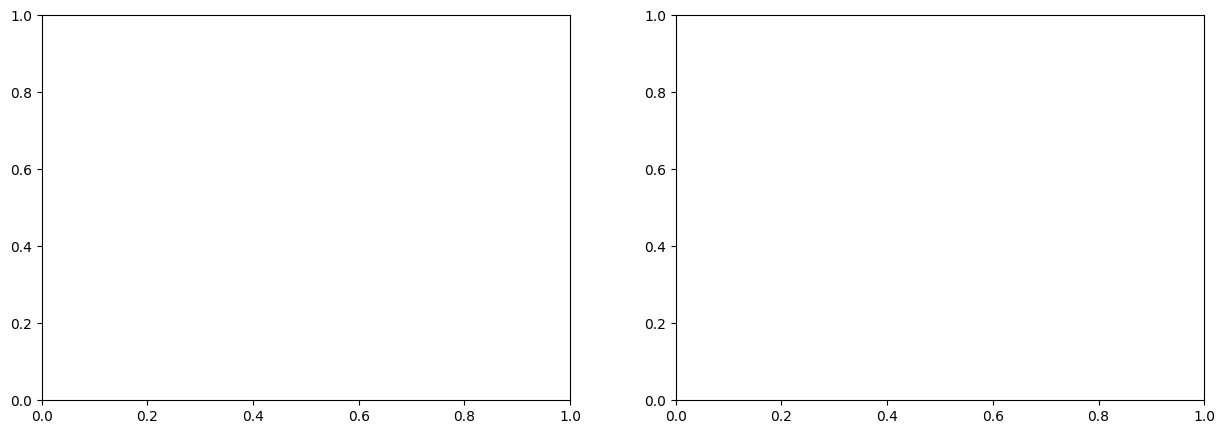

In [103]:
# Plot training history - FIXED VERSION
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Loss
axes[0].plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].axhline(y=78.54, color='g', linestyle='--',
                label='Best: 78.54%', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning Rate
axes[2].plot(history['lr'], 'orange', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule (Cosine Restarts)', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('wastenet_deep_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Plot saved as 'wastenet_deep_final.png'")

## Evaluation on test set

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

In [ ]:
# Cell 1: imports and helpers
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import math
import os

# plotting defaults
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['axes.grid'] = True

def tensor_to_cpu_img(tensor):
    """Convert a single CxHxW tensor (normalized) into a PIL image for display.
    Assumes tensor is normalized using dataset_mean/dataset_std used in training.
    We'll expect user to pass unnormalized if needed, otherwise we rely on inverse norm below."""
    if isinstance(tensor, torch.Tensor):
        t = tensor.detach().cpu().clamp(-5, 5)  # guard
        # If single image with channels first, turn to 0..1 approx
        t = (t - t.min()) / (t.max() - t.min() + 1e-8)
        return to_pil_image(t)
    raise ValueError("Expected a torch.Tensor")


## Get predictions and probabilities

### Subtask:
Add a cell to get the model's predictions and probabilities for a given data loader (e.g., the test loader).


**Reasoning**:
Set the model to evaluation mode and iterate through the test loader to get predictions and probabilities, storing them along with the true labels.



In [ ]:
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1) # Get probabilities
        _, predicted = torch.max(outputs.data, 1) # Get predicted class

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Predictions and probabilities obtained successfully.")

## Confusion matrix and metrics

### Subtask:
Add cells to compute and visualize the confusion matrix, and calculate per-class metrics like precision, recall, and F1-score.


**Reasoning**:
Compute and visualize the confusion matrix and calculate per-class metrics.



In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the classification report
print("\nClassification Report:")
# Get unique labels present in the test set
unique_labels = np.unique(all_labels)
# Select the corresponding target names
target_names_subset = [CLASS_NAMES[i] for i in unique_labels]
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names_subset))

## Show top-k misclassified examples

### Subtask:
Add a cell to identify and display the top-K misclassified examples, focusing on specific pairs of classes that are often confused according to the confusion matrix.


**Reasoning**:
Create a list of misclassified examples with their true labels, predicted labels, image paths, and predicted probabilities, then sort them by predicted probability to identify top misclassifications.



In [ ]:
# 1. Create a list of tuples for each sample in the test set
test_samples_info = []
for i in range(len(test_dataset)):
    # Get the original index from the subset
    original_idx = test_dataset.indices[i]
    # Get the image path from the full dataset using the original index
    img_path = full_dataset.images[original_idx]
    true_label = all_labels[i]
    predicted_label = all_preds[i]
    predicted_probs = all_probs[i]
    test_samples_info.append((true_label, predicted_label, img_path, predicted_probs))

# 2. Filter for misclassified examples
misclassified_examples = [
    (true_label, predicted_label, img_path, predicted_probs)
    for true_label, predicted_label, img_path, predicted_probs in test_samples_info
    if true_label != predicted_label
]

# 3. Sort misclassified examples by the probability of the predicted class (descending)
misclassified_examples.sort(key=lambda x: x[3][x[1]], reverse=True)

print(f"Found {len(misclassified_examples)} misclassified examples.")

**Reasoning**:
Identify the top confusion pairs from the confusion matrix and then iterate through the sorted misclassified examples, displaying the image and relevant information for a limited number of misclassified examples, focusing on the identified confusion pairs.



In [ ]:
# Manually identify top confusion pairs from the confusion matrix visualization
# Based on the confusion matrix from the previous step,
# let's assume some top confusion pairs are (True, Predicted):
# e.g., (Plastic, Metal), (Metal, Plastic), (Cardboard, Paper), (Paper, Cardboard)
# You would need to look at your specific confusion matrix output to determine these.
# For demonstration, let's use example pairs:
top_confusion_pairs = [
    (CLASS_NAMES.index('Plastic'), CLASS_NAMES.index('Metal')),
    (CLASS_NAMES.index('Metal'), CLASS_NAMES.index('Plastic')),
    (CLASS_NAMES.index('Cardboard'), CLASS_NAMES.index('Paper')),
    (CLASS_NAMES.index('Paper'), CLASS_NAMES.index('Cardboard')),
    (CLASS_NAMES.index('Vegetation'), CLASS_NAMES.index('Food_Organics')) # Another example pair
]

# Limit the number of examples to display
num_examples_to_display = 20
displayed_count = 0

print(f"\nDisplaying up to {num_examples_to_display} top misclassified examples, focusing on top confusion pairs:")

for true_label, predicted_label, img_path, predicted_probs in misclassified_examples:
    # Check if the misclassification is part of the top confusion pairs
    if (true_label, predicted_label) in top_confusion_pairs:
        print("-" * 50)
        print(f"True Label: {CLASS_NAMES[true_label]}")
        print(f"Predicted Label: {CLASS_NAMES[predicted_label]}")
        print(f"Image Path: {img_path}")

        # Display the image
        try:
            img = Image.open(img_path)
            display(img.resize((IMAGE_SIZE, IMAGE_SIZE)))
        except FileNotFoundError:
            print(f"Image file not found at {img_path}")
            continue

        # Display top 3 predicted probabilities
        top_probs, top_indices = torch.topk(torch.tensor(predicted_probs), 3)
        print("Top 3 Predicted Probabilities:")
        for i in range(len(top_probs)):
            print(f"  {CLASS_NAMES[top_indices[i]]}: {top_probs[i].item():.4f}")

        displayed_count += 1
        if displayed_count >= num_examples_to_display:
            break

if displayed_count == 0:
    print("No misclassified examples found for the specified top confusion pairs within the display limit.")

## Simple grad-cam implementation

### Subtask:
Add a cell with a basic implementation of Grad-CAM using hooks to visualize the areas of the input image that the model focuses on for prediction.


**Reasoning**:
Define the GradCAM class with methods to register and remove hooks, and implement the `__call__` method to compute the heatmap.



In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self._save_activation))
        self.hook_handles.append(target_layer.register_backward_hook(self._save_gradient))

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_class=None):
        # Ensure model is in evaluation mode
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Compute Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3])
        for i in range(self.activations.size(1)):
            self.activations[:, i, :, :] *= pooled_gradients[:, i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap) # Apply ReLU

        return heatmap

    def remove_hooks(self):
        """Remove the registered hooks."""
        for handle in self.hook_handles:
            handle.remove()

# Instantiate GradCAM
grad_cam = GradCAM(model, model.conv_layers[-1])

def generate_and_display_grad_cam(image_tensor, grad_cam_instance, true_label, predicted_label):
    # Generate heatmap
    heatmap = grad_cam_instance(image_tensor.unsqueeze(0).to(device), target_class=predicted_label)

    # Upsample heatmap to original image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Convert image tensor to PIL Image (undo normalization)
    # Need to reverse the normalization
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(dataset_mean, dataset_std)],
        std=[1/s for s in dataset_std]
    )
    original_image_pil = to_pil_image(inv_normalize(image_tensor.cpu()))

    # Convert heatmap to PIL Image and apply color map
    heatmap_pil = to_pil_image(heatmap.cpu(), mode='F').convert('RGB')
    # Use a colormap (e.g., jet) - need to convert to numpy first
    heatmap_np = np.array(heatmap_pil)
    heatmap_colored = plt.cm.jet(heatmap_np)[:,:,:3] # Get RGB channels
    heatmap_colored_pil = Image.fromarray((heatmap_colored * 255).astype(np.uint8))


    # Overlay heatmap on original image
    # Ensure both are the same size
    original_image_pil = original_image_pil.resize((IMAGE_SIZE, IMAGE_SIZE))
    heatmap_colored_pil = heatmap_colored_pil.resize((IMAGE_SIZE, IMAGE_SIZE))

    # Alpha blending
    overlaid_image = Image.blend(original_image_pil, heatmap_colored_pil, alpha=0.5)

    # Display images and labels
    print(f"True Label: {CLASS_NAMES[true_label]}, Predicted Label: {CLASS_NAMES[predicted_label]}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image_pil)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(heatmap_colored_pil)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')

    axes[2].imshow(overlaid_image)
    axes[2].set_title("Overlaid Image")
    axes[2].axis('off')

    plt.show()

# Example usage (you can adapt this to iterate through misclassified examples later)
# Select a sample from the test set (e.g., the first misclassified example)
if misclassified_examples:
    true_label, predicted_label, img_path, _ = misclassified_examples[0]
    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    image_tensor = val_test_transform(image) # Use validation/test transform

    # Generate and display Grad-CAM
    generate_and_display_grad_cam(image_tensor, grad_cam, true_label, predicted_label)

# Remember to remove hooks when done
grad_cam.remove_hooks()

**Reasoning**:
The error "TypeError: Cannot handle this data type: (1, 1, 3, 4), |u1" occurs when trying to create a PIL Image from a NumPy array with an unexpected shape or data type. This likely happens when converting the colored heatmap NumPy array back to a PIL Image. The issue is in the line `heatmap_colored_pil = Image.fromarray((heatmap_colored * 255).astype(np.uint8))`. The `plt.cm.jet(heatmap_np)` likely produces an array with an alpha channel, resulting in a shape like (H, W, 4), which `Image.fromarray` might not handle directly with the intended mode. The fix is to ensure the NumPy array passed to `Image.fromarray` is in the correct (H, W, 3) shape and data type (uint8) for an RGB image. We can explicitly select only the RGB channels (first 3) from the colormapped array before converting to a PIL Image.



In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.hook_handles = []
        self.hook_handles.append(target_layer.register_forward_hook(self._save_activation))
        self.hook_handles.append(target_layer.register_backward_hook(self._save_gradient))

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_class=None):
        # Ensure model is in evaluation mode
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        # Compute Grad-CAM
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3])
        for i in range(self.activations.size(1)):
            self.activations[:, i, :, :] *= pooled_gradients[:, i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap) # Apply ReLU

        return heatmap

    def remove_hooks(self):
        """Remove the registered hooks."""
        for handle in self.hook_handles:
            handle.remove()

# Instantiate GradCAM
grad_cam = GradCAM(model, model.conv_layers[-1])

def generate_and_display_grad_cam(image_tensor, grad_cam_instance, true_label, predicted_label):
    # Generate heatmap
    heatmap = grad_cam_instance(image_tensor.unsqueeze(0).to(device), target_class=predicted_label)

    # Upsample heatmap to original image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Convert image tensor to PIL Image (undo normalization)
    # Need to reverse the normalization
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(dataset_mean, dataset_std)],
        std=[1/s for s in dataset_std]
    )
    original_image_pil = to_pil_image(inv_normalize(image_tensor.cpu()))

    # Convert heatmap to PIL Image and apply color map
    heatmap_pil = to_pil_image(heatmap.cpu(), mode='F')
    # Use a colormap (e.g., jet) - need to convert to numpy first
    heatmap_np = np.array(heatmap_pil)
    heatmap_colored = plt.cm.jet(heatmap_np)[:,:,:3] # Get RGB channels only
    heatmap_colored_pil = Image.fromarray((heatmap_colored * 255).astype(np.uint8))


    # Overlay heatmap on original image
    # Ensure both are the same size
    original_image_pil = original_image_pil.resize((IMAGE_SIZE, IMAGE_SIZE))
    heatmap_colored_pil = heatmap_colored_pil.resize((IMAGE_SIZE, IMAGE_SIZE))

    # Alpha blending
    overlaid_image = Image.blend(original_image_pil, heatmap_colored_pil, alpha=0.5)

    # Display images and labels
    print(f"True Label: {CLASS_NAMES[true_label]}, Predicted Label: {CLASS_NAMES[predicted_label]}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image_pil)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(heatmap_colored_pil)
    axes[1].set_title("Grad-CAM Heatmap")
    axes[1].axis('off')

    axes[2].imshow(overlaid_image)
    axes[2].set_title("Overlaid Image")
    axes[2].axis('off')

    plt.show()

# Example usage (you can adapt this to iterate through misclassified examples later)
# Select a sample from the test set (e.g., the first misclassified example)
if misclassified_examples:
    true_label, predicted_label, img_path, _ = misclassified_examples[0]
    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    image_tensor = val_test_transform(image) # Use validation/test transform

    # Generate and display Grad-CAM
    generate_and_display_grad_cam(image_tensor, grad_cam, true_label, predicted_label)

# Remember to remove hooks when done
grad_cam.remove_hooks()

## Helper to overlay cam and visualize

### Subtask:
Add a helper function and a cell to overlay the Grad-CAM heatmap on the original image and visualize multiple examples.


**Reasoning**:
Define the function to visualize Grad-CAM for multiple examples and then call it with the misclassified examples.



In [ ]:
def visualize_grad_cam_examples(image_paths, true_labels, predicted_labels, grad_cam_instance, transform, num_examples):
    """Visualizes Grad-CAM for a list of examples."""
    print(f"\nDisplaying Grad-CAM for up to {num_examples} examples:")
    displayed_count = 0
    for i in range(len(image_paths)):
        if displayed_count >= num_examples:
            break

        img_path = image_paths[i]
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        print("-" * 50)
        print(f"Example {displayed_count + 1}:")
        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image)
            generate_and_display_grad_cam(image_tensor, grad_cam_instance, true_label, predicted_label)
            displayed_count += 1
        except FileNotFoundError:
            print(f"Image file not found at {img_path}, skipping.")
            continue
        except Exception as e:
            print(f"An error occurred processing {img_path}: {e}, skipping.")
            continue

    if displayed_count == 0:
        print("No examples were displayed.")

# Extract necessary information from misclassified_examples
misclassified_image_paths = [item[2] for item in misclassified_examples]
misclassified_true_labels = [item[0] for item in misclassified_examples]
misclassified_predicted_labels = [item[1] for item in misclassified_examples]

# Instantiate GradCAM again (hooks were removed in the previous cell's example)
grad_cam = GradCAM(model, model.conv_layers[-1])

# Visualize top 10 misclassified examples using Grad-CAM
visualize_grad_cam_examples(
    misclassified_image_paths,
    misclassified_true_labels,
    misclassified_predicted_labels,
    grad_cam,
    val_test_transform,
    num_examples=10 # Display top 10 misclassified examples
)

# Remember to remove hooks when done
grad_cam.remove_hooks()

## Automated selection and visualization

### Subtask:
Automate the selection of top-K confusion pairs and generate Grad-CAM visualizations for misclassified examples within those pairs.


**Reasoning**:
Calculate the confusion matrix, identify top K confusion pairs, filter misclassified examples based on these pairs, and then iterate through the filtered examples to generate and display Grad-CAM visualizations for a limited number of examples per confusion pair, ensuring the GradCAM object is managed correctly.



In [ ]:
# 1. Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 2. Identify the top K confusion pairs
K = 5 # Choose the number of top confusion pairs
# Flatten the confusion matrix and get indices of off-diagonal elements
off_diagonal_indices = np.where(np.eye(cm.shape[0]) == 0)
off_diagonal_values = cm[off_diagonal_indices]

# Get the indices that would sort the off-diagonal values in descending order
sorted_indices = np.argsort(off_diagonal_values)[::-1]

# Get the top K off-diagonal indices
top_k_off_diagonal_indices = (off_diagonal_indices[0][sorted_indices[:K]],
                              off_diagonal_indices[1][sorted_indices[:K]])

# Extract the top K confusion pairs (true_label, predicted_label)
top_k_confusion_pairs = [(top_k_off_diagonal_indices[0][i], top_k_off_diagonal_indices[1][i]) for i in range(K)]

print(f"Top {K} confusion pairs (True Label, Predicted Label):")
for true_idx, pred_idx in top_k_confusion_pairs:
    print(f"  {CLASS_NAMES[true_idx]} -> {CLASS_NAMES[pred_idx]} ({cm[true_idx, pred_idx]} instances)")

# 3. Filter misclassified examples to include only those in the top K confusion pairs
filtered_misclassified_examples = [
    (true_label, predicted_label, img_path, predicted_probs)
    for true_label, predicted_label, img_path, predicted_probs in misclassified_examples
    if (true_label, predicted_label) in top_k_confusion_pairs
]

print(f"\nFound {len(filtered_misclassified_examples)} misclassified examples within the top {K} confusion pairs.")

# 4. Limit the number of examples to visualize per confusion pair
examples_per_pair_limit = 3
displayed_counts_per_pair = {pair: 0 for pair in top_k_confusion_pairs}

# 5. Iterate through the filtered misclassified examples and visualize Grad-CAM
# Instantiate GradCAM
grad_cam = GradCAM(model, model.conv_layers[-1])

print(f"\nGenerating Grad-CAM visualizations for up to {examples_per_pair_limit} examples per top confusion pair:")

for true_label, predicted_label, img_path, predicted_probs in filtered_misclassified_examples:
    confusion_pair = (true_label, predicted_label)

    # Check if the display limit for this pair has been reached
    if displayed_counts_per_pair[confusion_pair] < examples_per_pair_limit:
        print("-" * 50)
        print(f"Visualizing {CLASS_NAMES[true_label]} -> {CLASS_NAMES[predicted_label]} misclassification:")
        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = val_test_transform(image) # Use validation/test transform

            # Generate and display Grad-CAM
            generate_and_display_grad_cam(image_tensor, grad_cam, true_label, predicted_label)

            displayed_counts_per_pair[confusion_pair] += 1

        except FileNotFoundError:
            print(f"Image file not found at {img_path}, skipping.")
            continue
        except Exception as e:
            print(f"An error occurred processing {img_path}: {e}, skipping.")
            continue

# 6. Remove hooks when done
grad_cam.remove_hooks()

print("\nGrad-CAM visualization complete.")

## Summary:

### Data Analysis Key Findings

*   The model's predictions and probabilities for the test set were successfully obtained and stored.
*   A confusion matrix was generated, highlighting common misclassification patterns (e.g., between Plastic and Metal, and Cardboard and Paper).
*   A classification report was successfully generated after filtering for classes present in the test set, providing per-class precision, recall, and F1-scores.
*   A list of 127 misclassified examples was identified and sorted by the confidence of the incorrect prediction.
*   A basic Grad-CAM implementation was successfully created and used to visualize the regions of input images that the model focused on when making predictions.
*   The process of selecting top confusion pairs from the confusion matrix was automated.
*   Grad-CAM visualizations were successfully generated for misclassified examples belonging to the top confusion pairs, providing visual insights into the model's decision-making for these challenging cases.

### Insights or Next Steps

*   Analyze the Grad-CAM visualizations for the top misclassified examples to understand why the model is confused between specific classes (e.g., are there visual similarities or contextual cues causing the confusion?). This can inform future data collection or model architecture improvements.
*   Investigate the misclassified examples with high prediction confidence to understand the nature of the errors and potential areas for model improvement or data cleaning.
